# Project 2: Ames Housing Data and Kaggle Challenge

## Problem statement

To predict the price of houses by creating a regression model using the Ames Housing Dataset.

## Executive Summary

### Contents:
- [Data Exploration](#Data-Exploration) 
- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
- [Conclusion](#Conclusion)

## Data Exploration

### Import Libraries & Dataset

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

%matplotlib inline

pd.set_option('display.max_rows', 100) # to look at more rows of data later
pd.set_option('display.max_columns', 100) # to expand columns view so that all can be seen later

In [2]:
# Load datasets
train_df = pd.read_csv('../datasets/train.csv')
test_df = pd.read_csv('../datasets/test.csv')

### Identify Data Types in Dataset

In [3]:
# For this case, we will only need to check train_df since both have the same column data
train_df.dtypes

Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
B

#### Observations

From our understanding of the data dictionary, <b>MS Sub Class</b> is considered as categorical data despite being a numerical column (the value represents class of the building), so this will be required to be converted later.

Same goes for <b>Mo Sold</b> as well, since the value represents the month in a year and not the value.

The following columns: <b>Yr Sold, Year Built, Year Remod/Add, Garage Yr Blt</b> are all in years even though they are numeric.
Instead of using them as it is, we can use these values to calculate 3 new values that may make more sense, namely:

1. age_house = Yr Sold - Year Built<br>
This is to calculate the age of the house when it was sold
2. num_years_remod = Yr Sold - Year Remod/Add <br>
This is to calculate year difference between the year it was sold and the year it was remod.
3. age_garage = Yr Sold - Garage Yr Blt<br>
This is to calculate the age of the garage when it was sold. If age is 0, it means there is no garage present.


### Check for amount of null values per column

In [4]:
# For training data
s = pd.Series(train_df.isnull().mean().sort_values(ascending=False))
s[s > 0]

Pool QC           0.995612
Misc Feature      0.968308
Alley             0.931741
Fence             0.804973
Fireplace Qu      0.487567
Lot Frontage      0.160897
Garage Finish     0.055583
Garage Cond       0.055583
Garage Qual       0.055583
Garage Yr Blt     0.055583
Garage Type       0.055095
Bsmt Exposure     0.028279
BsmtFin Type 2    0.027304
BsmtFin Type 1    0.026816
Bsmt Cond         0.026816
Bsmt Qual         0.026816
Mas Vnr Type      0.010726
Mas Vnr Area      0.010726
Bsmt Half Bath    0.000975
Bsmt Full Bath    0.000975
Garage Cars       0.000488
Garage Area       0.000488
Bsmt Unf SF       0.000488
BsmtFin SF 2      0.000488
Total Bsmt SF     0.000488
BsmtFin SF 1      0.000488
dtype: float64

In [5]:
# for test data
s = pd.Series(test_df.isnull().mean().sort_values(ascending=False))
s[s > 0]

Pool QC           0.995449
Misc Feature      0.953356
Alley             0.934016
Fence             0.804323
Fireplace Qu      0.480091
Lot Frontage      0.182025
Garage Cond       0.051195
Garage Qual       0.051195
Garage Yr Blt     0.051195
Garage Finish     0.051195
Garage Type       0.050057
Bsmt Exposure     0.028441
BsmtFin Type 1    0.028441
Bsmt Qual         0.028441
BsmtFin Type 2    0.028441
Bsmt Cond         0.028441
Mas Vnr Area      0.001138
Mas Vnr Type      0.001138
Electrical        0.001138
dtype: float64

#### Observations

For the features <b>Pool QC, Misc Feature</b> and <b>Alley</b>, since > 90% of the data values are null, we will drop the columns completely.
Remaining null values above will be required to be filled in later.

### Logic checking between columns/Relationship between columns

We will need to check the following columns to ensure the columns are logically sound.
This is also to validate the relationship between the columns.

1. Yr Sold >= Garage Yr Blt/Year Built
2. Year Remod/Add >= Year Built
3. Total Bsmt SF = BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF
4. Gr Liv Area = 1st Flr SF + 2nd Flr SF + Low Qual Fin SF


### Any other new insights we can gather with existing data?

Assuming the above relationship holds, we can choose to calculate the overall area of the house (which we can name as overallsf). <br>
Calculation of the overall will be as follows: <br>

overallsf = Gr Liv Area + Total Bsmt SF

This will give us a more general idea of the size of the house, which may help us to determine how size affects the price of a house.

During feature selection, we can drop BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, 1st Flr SF, 2nd Flr SF and Low Qual Fin SF to avoid multicollinearity issues when doing our modeling.

Additionally, looking at the data dictionary, <b>Garage Cars</b> and <b>Garage Area</b> are both measurements of the garage but with different units. We may opt to drop <b>Garage Cars</b> because of collinearity issues as well.

The data dictionary have also highlighted that houses with <b>Gr Liv Area greater than 4000</b> to be removed as those are deemed as outliers, which will need to be taken care of.

## Data Cleaning

### Pre-Cleaning Phase

We will lowercase and remove all spacings and special characters.<br>
After which we will verify and check that the columns in both train and test dataset are the same (with the exception of saleprice in train data)

In [6]:
# lowercase and remove spacings + special characters (in this case "/") in column names
train_df.columns = train_df.columns.str.lower().str.replace(' ','').str.replace('/','')
test_df.columns = test_df.columns.str.lower().str.replace(' ','').str.replace('/','')

In [7]:
missingcol = [i for i in train_df.columns if (i not in test_df) and i != 'saleprice']
print(missingcol)

[]


### Check uniqueness of data

Check if id and pid are unique in each dataset, if yes then we will drop the PID column and use ID as the index.

In [8]:
def check_drop_ids(df):
    if df['id'].nunique() == df.shape[0]:
        df.set_index('id',inplace=True)
    if df['pid'].nunique() == df.shape[0]:
        df.drop(['pid'],axis=1,inplace=True)

check_drop_ids(train_df)
check_drop_ids(test_df)

### Logic check

We will check if the data fulfills the logical requirements, and we will drop them if required.

In [9]:
# Logic check for Yr Sold >= Garage Yr Blt/Year Built for train_df

train_df[(train_df['yrsold'] < train_df['garageyrblt']) | (train_df['yrsold'] < train_df['yearbuilt'])]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2261,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,267300
2181,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


The above checks show that the garageyrblt for that data row for id 2261 in train_df is invalid as it is 2207, far beyond our current year.
This is likely a typo, so we will change the value to the most probable year, which in this case is 2007. 

In [10]:
train_df.loc[train_df['garageyrblt'] == 2207,'garageyrblt'] = 2007

For index 2181 of train_df, it seems that the house is sold even before the house is built.
Assumption here is that the house needs to be built before it can be sold, so we will drop this row.


In [11]:
train_df.drop(index=2181,inplace=True)

In [12]:
# Logic check for Yr Sold >= Garage Yr Blt/Year Built for test_df
test_df[(test_df['yrsold'] < test_df['garageyrblt']) | (test_df['yrsold'] < test_df['yearbuilt'])]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [13]:
# Logic check for Year Remod/Add >= Year Built for train_df
train_df[(train_df['yearremodadd'] < train_df['yearbuilt'])]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
851,20,RL,65.0,10739,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2002,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,68.0,Gd,TA,PConc,Gd,TA,No,GLQ,1259.0,Unf,0.0,172.0,1431.0,GasA,Ex,Y,SBrkr,1444,0,0,1444,1.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2002.0,RFn,2.0,577.0,TA,TA,Y,144,40,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,203000


For id 851 in train_df, Year Remod/Add occurred before the Year Built, which is not the case logically. <br>
Decision: row to be dropped.

In [14]:
train_df.drop(index=851,inplace=True)

In [15]:
# Logic check for Year Remod/Add >= Year Built for test_df
test_df[(test_df['yearremodadd'] < test_df['yearbuilt'])]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [16]:
# Logic Check for Total Bsmt SF = BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF for train_df
train_df[train_df['bsmtfinsf1'] + train_df['bsmtfinsf2']+train_df['bsmtunfsf'] != train_df['totalbsmtsf']]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1342,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,79000


For index 1342, we see that the values for the features related to bsmt are null, which may indicate that this house may not have a basement.<br>
Decision: This will be handled later when we are filling up null values.

In [17]:
# Logic Check for Total Bsmt SF = BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF for test_df
test_df[test_df['bsmtfinsf1'] + test_df['bsmtfinsf2']+ test_df['bsmtunfsf'] != test_df['totalbsmtsf']]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [18]:
# Logic Check for Gr Liv Area = 1st Flr SF + 2nd Flr SF + Low Qual Fin SF for train_df
train_df[train_df['1stflrsf'] + train_df['2ndflrsf'] + train_df['lowqualfinsf'] != train_df['grlivarea']][['1stflrsf','2ndflrsf','lowqualfinsf','grlivarea']]

,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea
id,,,,


In [19]:
# Logic Check for Gr Liv Area = 1st Flr SF + 2nd Flr SF + Low Qual Fin SF for test_df
test_df[test_df['1stflrsf'] + test_df['2ndflrsf'] + test_df['lowqualfinsf'] != test_df['grlivarea']]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Filling of null values

For categorical null values, we will replace with the default NA/None.

In [20]:
# Writing a function to fill the null values for the categorical variables
# For now we will fill all null values with default NA/None value. Further exploration might be needed if this assumption is too generalistic.
def fill_cat_null(df,list_of_col):
    for i in list_of_col:
        if i == 'masvnrtype': # Based on data dictionary, the default none value for this case is None and not NA
            df[i] = df[i].fillna('None')
        else:
            df[i] = df[i].fillna('NA')
    return df

traincol_cat_null = [i for i in train_df.columns if (train_df[i].dtypes == np.object) & (train_df[i].count() < train_df.shape[0])]
testcol_cat_null = [i for i in test_df.columns if (test_df[i].dtypes == np.object) & (test_df[i].count() < test_df.shape[0])]

train_df = fill_cat_null(train_df,traincol_cat_null)
test_df = fill_cat_null(test_df,testcol_cat_null)

For numerical values, we will replace all null values to 0.

In [21]:
traincol_num_null = [i for i in train_df.columns if (train_df[i].dtypes == np.float64) & (train_df[i].count() < train_df.shape[0])]
testcol_num_null = [i for i in test_df.columns if (test_df[i].dtypes == np.float64) & (test_df[i].count() < test_df.shape[0])]
for i in traincol_num_null:
    train_df[i] = train_df[i].fillna(0)
    
for i in testcol_num_null:
    test_df[i] = test_df[i].fillna(0)


## Feature Engineering

### Conversion of column types for categorial data

As observed in our exploration of data, <b>MS Sub Class</b> and <b>Mo Sold</b> will need to be converted to string values as they are classified as categorial data and not numeric values.

In [22]:
def convert_to_string(df,list_of_column):
    for i in list_of_column:
        df[i] = df[i].astype(str)
    return df

train_df = convert_to_string(train_df,['mssubclass','mosold'])
test_df = convert_to_string(test_df,['mssubclass','mosold'])

### Calculate new values using existing data

From our exploration earlier, we can calculate values that we can include as our features during feature slection later. The following values will be calculated:

1. age_house = Yr Sold - Year Built<br>
This is to calculate the age of the house when it was sold
2. num_years_remod = Yr Sold - Year Remod/Add <br>
This is to calculate year difference between the year it was sold and the year it was remod.
3. age_garage = Yr Sold - Garage Yr Blt<br>
This is to calculate the age of the garage when it was sold. If age is 0, it means there is no garage present.
4. overallsf = Gr Liv Area + Total Bsmt SF <br>
This is to calculate the overall area of the house in square feet

In [23]:
def perform_all_calc(df):
    df['age_house'] =  df['yrsold'] - df['yearbuilt'] # calculate age of house
    df['years_after_remod'] = df['yrsold'] - df['yearremodadd'] #calculate years after remod
    # For the age of garage, as some of the garageyrblt was set to 0 due to it being null, 
    # age_garage will be 0 if garageyrblt is 0.
    df['age_garage'] = df['yrsold'] - df['garageyrblt']
    df.loc[df['garageyrblt'] == 0,'age_garage'] = 0
    df['overallsf'] = df['grlivarea'] + df['totalbsmtsf']
    return df

train_df = perform_all_calc(train_df)
test_df = perform_all_calc(test_df)


In [24]:
# Check for anomalies in calculated data
train_df[['age_house','years_after_remod','age_garage','overallsf']].describe()

,age_house,years_after_remod,age_garage,overallsf
count,2049.000000,2049.000000,2049.000000,2049.000000
mean,36.099073,23.605661,27.575891,2552.921425
std,30.207865,21.020909,25.154274,793.438169
min,0.000000,-1.000000,0.000000,334.000000
25%,7.000000,4.000000,4.000000,2010.000000
50%,34.000000,15.000000,22.000000,2457.000000
75%,54.000000,43.000000,46.000000,2998.000000
max,136.000000,60.000000,114.000000,11752.000000


In [25]:
test_df[['age_house','years_after_remod','age_garage','overallsf']].describe()

,age_house,years_after_remod,age_garage,overallsf
count,879.000000,879.000000,879.000000,879.000000
mean,37.291240,23.379977,29.424346,2537.282139
std,30.477921,20.486428,25.982356,792.419246
min,0.000000,-1.000000,0.000000,720.000000
25%,8.000000,5.000000,5.000000,1978.000000
50%,36.000000,15.000000,28.000000,2432.000000
75%,54.500000,41.000000,47.000000,2983.000000
max,129.000000,60.000000,110.000000,7814.000000


### Drop outliers

Those houses with Gr Liv Area > 4000 will be dropped. This is as mentioned in the data dictionary.

In [26]:
train_df = train_df[train_df['grlivarea'] <= 4000]

### Drop unnecessary columns

The columns are dropped as they will not be considered for feature selection.

In [27]:
columns_to_drop = ['poolqc','miscfeature','alley','yrsold', 'yearbuilt', 'yearremodadd', 'garagecars',
                   'garageyrblt','bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','1stflrsf','2ndflrsf',
                   'grlivarea','1stflrsf','2ndflrsf','lowqualfinsf']

train_df.drop(columns_to_drop, axis=1,inplace=True)
test_df.drop(columns_to_drop, axis=1,inplace=True)

### Encode ordinal data

The following data columns are identified as ordinal based on the data dictionary:

lotshape, utilities, landslope, overallqual,overallcond,exterqual,extercond, bsmtqual,bsmtcond, bsmtexposure, bsmtfintype1, bsmtfintype2, heatingqc, electrical, kitchenqual, functional, fireplacequ, garagefinish,garagequal,garagecond,paveddrive, fence

In [28]:
qualcond_val_dict = {'Ex': 5,
                   'Gd' : 4,
                   'TA' : 3,
                   'Fa' : 2,
                   'Po' : 1,
                   'NA' : 0 }

bsmttype_val_dict = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}

encode_dict = {'lotshape': {'Reg': 4,'IR1':3,'IR2':2,'IR3':1},
              'utilities': {'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1},
              'landslope': {'Gtl':3,'Mod':2,'Sev':1,'NA':0},                    
              'exterqual': qualcond_val_dict,
              'extercond': qualcond_val_dict,
              'bsmtqual': qualcond_val_dict,
              'bsmtcond': qualcond_val_dict,
              'bsmtexposure': {'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0},
              'bsmtfintype1': bsmttype_val_dict,
              'bsmtfintype2': bsmttype_val_dict,
              'heatingqc': qualcond_val_dict,
              'electrical': {'SBrkr':5,'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1,'NA':0},
              'kitchenqual': qualcond_val_dict,
              'functional': {'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1,'NA':0},
              'fireplacequ': qualcond_val_dict,
              'garagefinish': {'Fin':3,'RFn':2,'Unf':1,'NA':0},
              'garagequal': qualcond_val_dict,
              'garagecond': qualcond_val_dict,
              'paveddrive': {'Y':3,'P':2,'N':1,'NA':0},
              'fence': {'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'NA':0}}

train_df.replace(encode_dict,inplace=True)
test_df.replace(encode_dict,inplace=True)

In [29]:
# Check type and change if necessary

def change_type(df,dict):
    for i in df.columns:
        if (df[i].dtypes == np.object) and (i in dict.keys()):
            df[i] = df[i].astype(int)
    return df

train_df = change_type(train_df,encode_dict)
test_df = change_type(test_df,encode_dict)


### Add dummies for categorical data

We will split the columns for the categorical data into dummy columns.
Once that is done, we will remove all the columns that are not present in either train/test dataset.

In [30]:
features_cat = [i for i in train_df.columns if (i != 'salesprice') and (train_df[i].dtypes == np.object)]
train_df = pd.get_dummies(train_df, columns=features_cat, drop_first=True)
test_df = pd.get_dummies(test_df, columns=features_cat, drop_first=True)

In [31]:
# Drop columns that does not exist in test_df/train_df except saleprice
for i in train_df.columns:
    if (i not in test_df.columns) and (i != 'saleprice'):
        train_df.drop([i],axis=1,inplace=True)

for i in test_df.columns:
    if i not in train_df.columns:
        test_df.drop([i],axis=1,inplace=True)

In [32]:
print(test_df.shape)
print(train_df.shape)

(879, 187)
(2048, 188)


## Exploratory Data Analysis

Do a quick correlation check between sales price and the feature

In [33]:
top_20_features = np.abs(train_df.corr()[['saleprice']]).sort_values(by='saleprice',ascending=False).head(21).T.columns
top_20_features

Index(['saleprice', 'overallsf', 'overallqual', 'exterqual', 'kitchenqual',
       'garagearea', 'bsmtqual', 'age_house', 'garagefinish',
       'years_after_remod', 'fireplacequ', 'fullbath', 'foundation_PConc',
       'masvnrarea', 'totrmsabvgrd', 'fireplaces', 'heatingqc',
       'neighborhood_NridgHt', 'age_garage', 'bsmtexposure',
       'masvnrtype_None'],
      dtype='object')

Text(0.5, 1, 'Correlation between Sale Prices & Features')

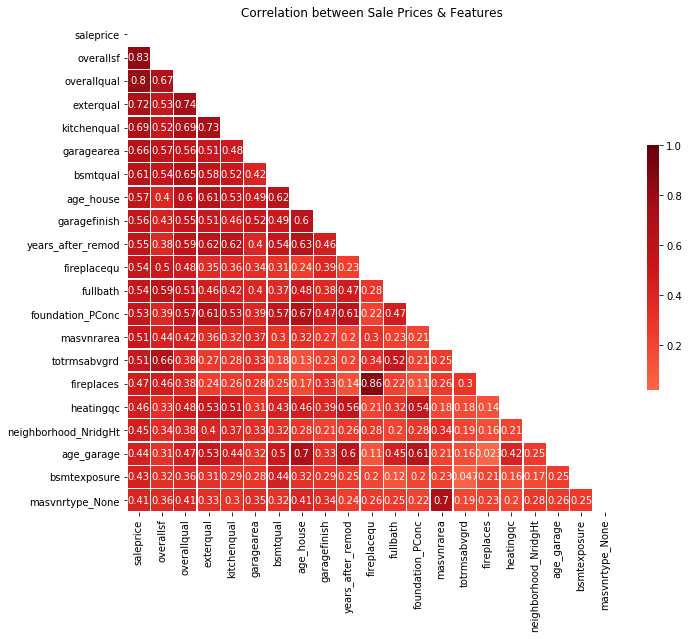

In [34]:
corr = train_df[top_20_features].corr().abs().sort_values(by='saleprice',ascending=False)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Reds', vmax=1, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Correlation between Sale Prices & Features')

We shall plot scatterplots and histograms to examine the relationship between the sale price and the features chosen.

In [35]:
def subplot_scatter(dataframe, column_x):
    nrows = int(np.ceil(len(column_x)/2)) # Makes sure you have enough rows
   #ncols = int(len(column_x))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (20, 20))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(column_x): # Gives us an index value to get into all our lists
        sns.regplot(x = column, y = 'saleprice', data = dataframe, ax = ax[i], color ='b')
        ax[i].set_title('Scatter of {} and {}'.format(column_x[i], 'saleprice'), fontsize = 12)
        ax[i].set_xlabel(column_x[i].replace('_', ' ').title(), fontsize = 12)
        ax[i].set_ylabel('saleprice', fontsize = 12)
       #ax[i].legend(column_x, loc = 'upper right')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

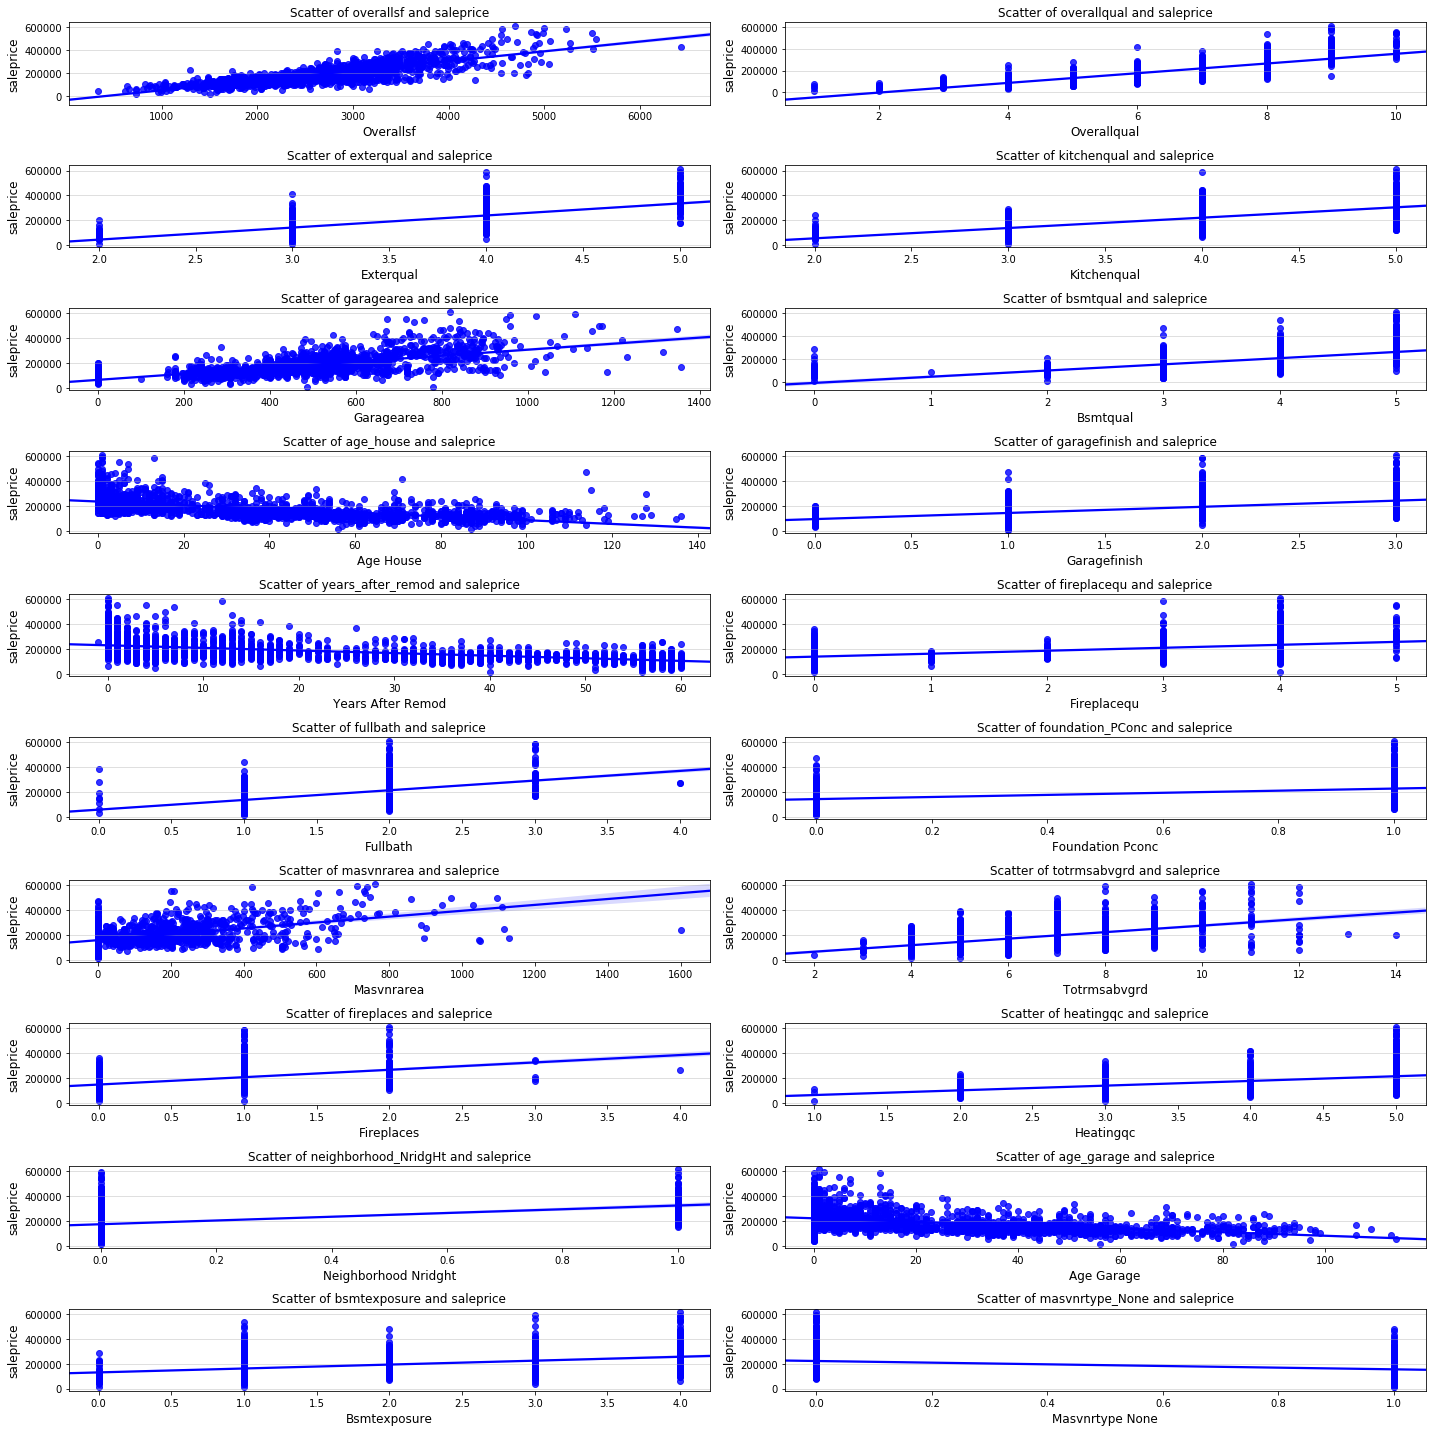

In [36]:
subplot_scatter(train_df,corr.columns[1:21])

From the scatterplots, we do see that prices of houses are generally higher for houses that have a greater area and better quality. Prices are also lower for older houses, garages and houses that has not been remod for a longer period of time.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD755139E8>,
      dtype=object)

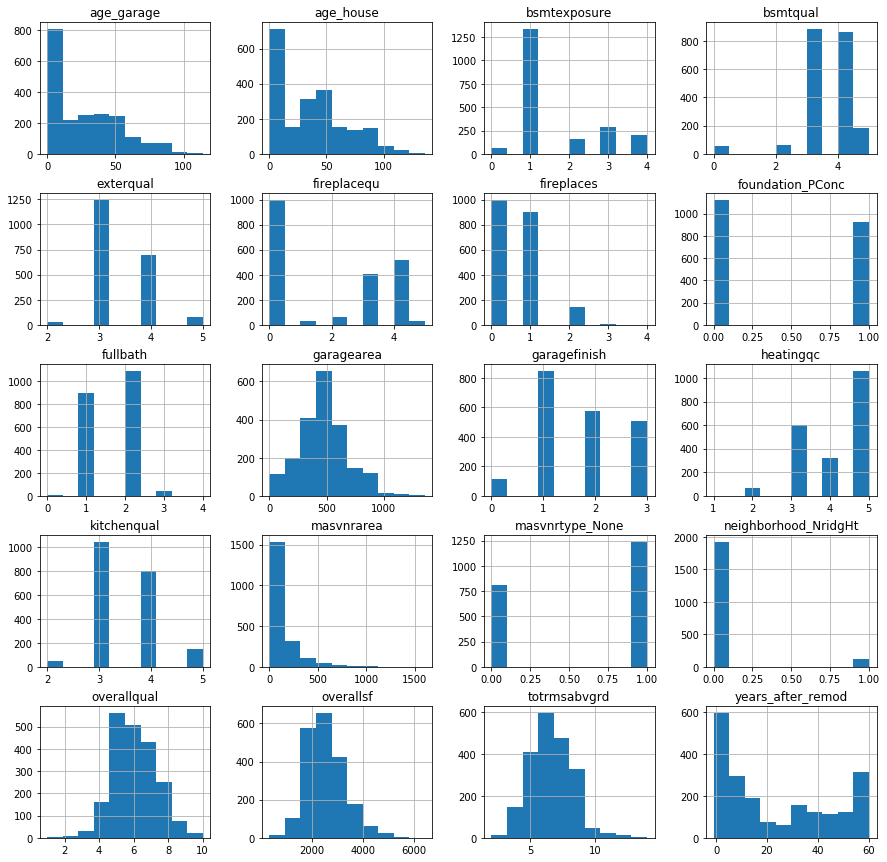

In [37]:
train_df[corr.columns[1:21]].hist(figsize=(15,15))

From the histograms, we can see that most of the features are mainly skewed to the right.

## Modeling

We first write functions that will help in our modelling process later.

In [38]:
def run_all_model(X,y): # This is to run all the different regression models
    model_list = ['lr','lasso','ridge','elasticnet']
    for i in model_list:
        print(f'Score for {i}: {run_model(i,X,y)}') 

def run_model(model_name,X,y): # This is to run model based on the model chosen.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
    X_train_sc, X_test_sc = run_SS(X_train,X_test)
    
    model = get_model(model_name)
    score = cross_val_score(model,X_train_sc,y_train,cv=5).mean()
    
    return score

def run_SS(X_train,X_test): # Initialise StandardScaler
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    return X_train_sc, X_test_sc

def get_model(model_name): # Initialise model to use to run
    model_dict = {
        'lr': LinearRegression(),
        'lasso': LassoCV(cv=3,max_iter=100000),
        'ridge': RidgeCV(),
        'elasticnet': ElasticNetCV(alphas=np.arange(0.5, 1.0, 0.005),cv=3,max_iter=100000)
    }
    return model_dict.get(model_name)

def run_full_model(X_train,y,model_name): # this is to fit the full train data into the model
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    model = get_model(model_name)
    model.fit(X_train_sc,y)
    score = model.score(X_train_sc,y)
    print(f'Score after fitting full training set: {score}')
    coef = model.coef_
    pred = model.predict(X_train_sc)
    residuals = y - pred
    return model.fit(X_train_sc,y), coef, pred

def predict_values(model,X_kaggle): # This function is to predict the test data that is to be uploaded to kaggle later
    ss = StandardScaler()
    X_kaggle_sc = ss.fit_transform(X_kaggle)
    return model.predict(X_kaggle_sc)

def predict_store_val(model_name,X_train,y,X_kaggle,file): # This is to predict the saleprice and store in csv
    fitted_model, coef, pred_train = run_full_model(X_train,y,model_name)
    pred = predict_values(fitted_model,X_kaggle)
    store_val(pred,file)
    return coef, pred_train
    
def store_val(pred,file): # Saves the predicted data into a csv
    # Create dataframe for Kaggle submission
    df_soln = pd.DataFrame(test_df.index)
    df_soln.rename(columns={'id':'Id'},inplace=True)
    df_soln['SalePrice'] = pred
    df_soln.set_index(['Id'], inplace=True)
    df_soln.to_csv(f'../datasets/{file}.csv')
    
def plot_residuals(pred,y): # This is to plot the residual graph
    residual = y - pred
    plt.scatter(pred,residual)
    plt.axhline(y=0,c='red')

def plot_coef(coef,index): # This is to show the coefficient graph
    pd.Series(coef, index=index).plot.bar(figsize=(15, 7))

### Model 1: Using the top 20 features that are strongly correlated with sale price.

In [39]:
features = corr.columns[1:21]
X = train_df[features]
y = train_df['saleprice']
X_kaggle = test_df[features]

In [40]:
run_all_model(X,y)

Score for lr: 0.8671427271526209
Score for lasso: 0.8672310115497208
Score for ridge: 0.8672831470932177
Score for elasticnet: 0.8602845817644343


Applying ridge regression to fit and predict the sale price since it has the highest score.

In [41]:
coef, pred = predict_store_val('ridge',X,y,X_kaggle,'Model1')

Score after fitting full training set: 0.8673524833799027


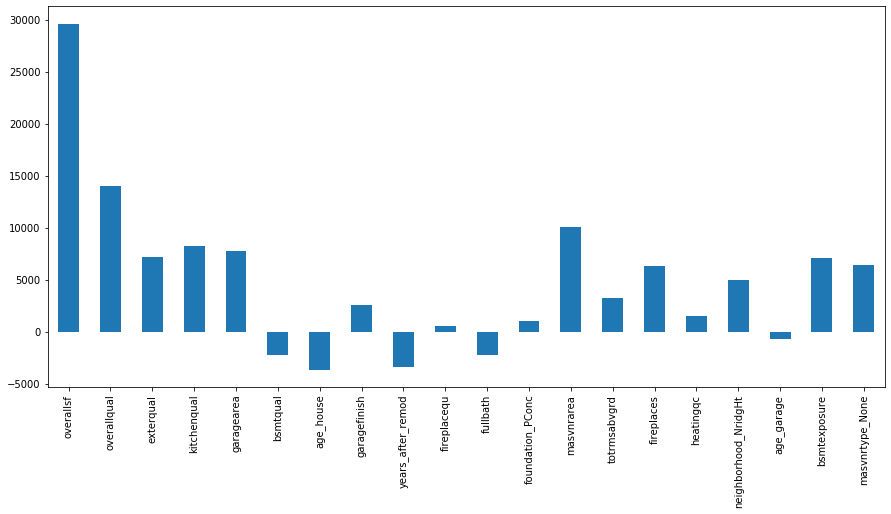

In [42]:
plot_coef(coef,features)

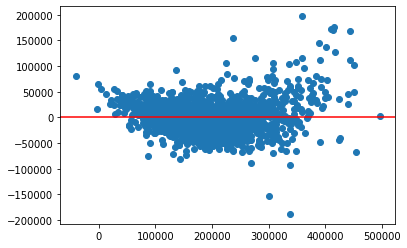

In [43]:
plot_residuals(pred,y)

Private Score: 33345.50812 <br>
Public Score: 34100.80685 <br>
Aggregated Score: 33572.09774

### Model 2: Applying polynomial features on the top 20 features and choosing the top 20 features from it.

In [44]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
poly_train = pd.DataFrame(X_poly, columns = poly.get_feature_names(features),index=train_df.index)
poly_train['saleprice'] = train_df['saleprice']

X_poly_features = np.abs(poly_train.corr()[['saleprice']]).sort_values(by='saleprice',ascending=False)[1:21]
X_poly_features_columns = X_poly_features.T.columns

run_all_model(poly_train[X_poly_features_columns],y)

Score for lr: 0.8911682495617942
Score for lasso: 0.8916077898148467
Score for ridge: 0.8917525033060905
Score for elasticnet: 0.8774743099678481


In [45]:
X_kaggle_poly = poly.transform(X_kaggle)
poly_kaggle = pd.DataFrame(X_kaggle_poly,columns=poly.get_feature_names(features))

coef_model2, pred_model2 = predict_store_val('ridge',poly_train[X_poly_features_columns],y,poly_kaggle[X_poly_features_columns],'Model2')


Score after fitting full training set: 0.8929239608943331


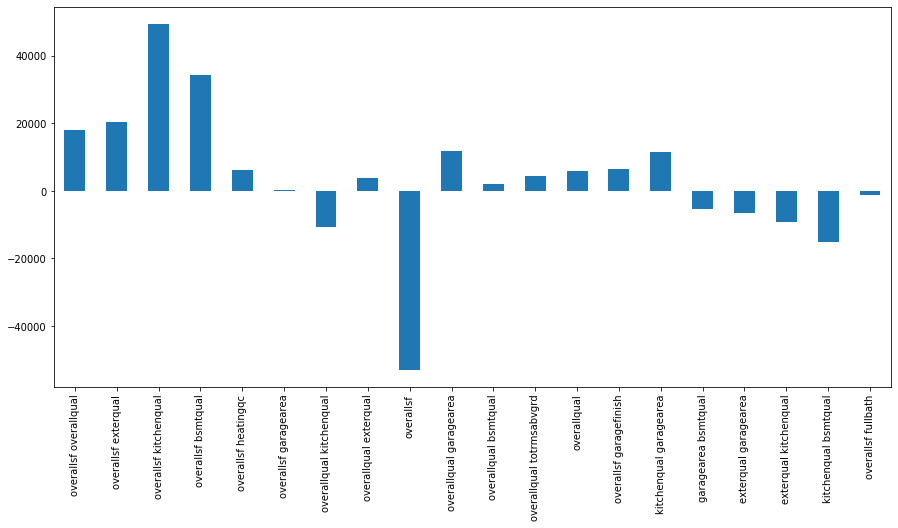

In [46]:
plot_coef(coef_model2,X_poly_features_columns)

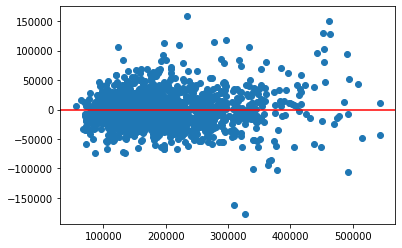

In [47]:
plot_residuals(pred_model2,y)

Public Score: 27718.98259 <br>
Private Score: 34613.57548 <br>
Aggregated Score: 32545.19761

Based on the above 2 models, we will opt to use model 2 to predict the house values.

## Conclusion

From the above 2 models, even though we observe a good improvement in score for the public score in model 2, the private score remains almost consistent across the 2 models, which sort of indicates a slight overfitting in the model itself. But model 2 still shows to be a better predictor as compared to model 1 since the RMSE for the private scores remain fairly consistent for the private scores but improves for the public ones.

The way we clean our data may also impact our feature selection as well, so further experiments on the cleaning process can be done. For example, instead of replacing null values with default NAs or 0, we can try finding the mean/mode/median of the feature and replace those null values with it instead.